In [1]:

from polygon import RESTClient
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import time



def calculate_ema(data, period):
  return data.ewm(span=period, adjust=False).mean()

def calculate_macd(data):
  ema_12 = calculate_ema(data, 12)
  ema_26 = calculate_ema(data, 26)
  macd_line = ema_12 - ema_26
  signal_line = calculate_ema(macd_line, 9)
  return macd_line, signal_line

def generate_date_array(year):
    dates = []
    # Start from the first day of the given year
    current_date = datetime(year, 1, 1)
    # End on the last day of the given year
    end_date = datetime(year + 1, 1, 1)
    
    while current_date < end_date:
        # Format the date as "yyyy-mm-dd" and add it to the list
        date_string = current_date.strftime("%Y-%m-%d")
        dates.append(date_string)
        # Move to the next day
        current_date += timedelta(days=1)
    
    return dates

def graph_profits(data, type_of_profit):
    # Extract keys and values
    dates = list(data.keys())
    values = list(data.values())

    # Convert string dates to datetime objects
    dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]

    # Create a plot
    plt.figure(figsize=(8, 4))
    plt.plot(dates, values, marker='o', linestyle='-', color='b')

    # Format the x-axis to show dates properly
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())

    # Label the axes
    plt.xlabel('Date')
    plt.ylabel(type_of_profit)
    plt.title(f'Model {type_of_profit} vs Holding Stock')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()

def graph_transactions(transactions):
  # Convert transactions to a DataFrame for easier manipulation
  df = pd.DataFrame(transactions, columns=['Date', 'Price', 'Type'])

  # Convert the 'Date' column to datetime objects
  df['Date'] = pd.to_datetime(df['Date'])

  # Separate the transactions by type
  sell_transactions = df[df['Type'] == 'Sell']
  buy_transactions = df[df['Type'] == 'Buy']

  # Plotting
  plt.figure(figsize=(6, 4))

  # Plot sell transactions in red
  plt.scatter(sell_transactions['Date'], sell_transactions['Price'], color='red', label='Sell', marker='x')

  # Plot buy transactions in green
  plt.scatter(buy_transactions['Date'], buy_transactions['Price'], color='green', label='Buy', marker='o')
  
  

  # Labels and title
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.title('Transaction Prices Over Time')
  plt.legend()

  # Format the date on the x-axis
  plt.gcf().autofmt_xdate()

  # Show the plot
  plt.show()


def get_data(ticker, start_date, end_date):
    client = RESTClient("InxdvvQ5aFMwk5xWUpJUCpe8YHcimh8d")
    aggs = client.get_aggs(ticker, 1, "day", start_date, end_date, limit=50000)
    print("Number of Data Points:",len(aggs))
    return aggs

In [2]:
def run_simulation(ticker, start_date, end_date, init_cash, init_shares, percent_invest, prices, times, buys, sells):
  transaction_times = sorted(buys + sells)
  transactions = []
  for t in transaction_times:
    price = prices[times.index(t)]
    if t in buys:
      transactions.append([t, price, "Buy"])
    else:
      transactions.append([t, price, "Sell"])
  
  # print("Transactions: ", transactions)
  graph_transactions(transactions)
  # Execute Transactions through simulation
  cash = init_cash
  shares = init_shares
  print("Running Simulation for MACD with", ticker, "from", start_date, "to", end_date)
  print("Number of Transactions: ", len(transactions))
  print("Buys: ", len(buys), "Sells: ", len(sells))
  print("Open Price, Close Price: ", prices[0], prices[-1])
  print("Beginning Cash and Shares: ", cash, shares)
  portfolio_val_s = cash + prices[0] * shares
  print("Beginning Portfolio Value: ", portfolio_val_s)
  amt = cash * percent_invest / 100
  for order in transactions:
    if order[2] == "Buy":
      cash -= amt
      shares += amt/order[1]
    else:
      cash += amt
      shares -= amt/order[1]
  print("End Cash and Shares: ", cash, shares)
  portfolio_val_e = cash + prices[-1] * shares
  profit = portfolio_val_e - portfolio_val_s
  profit_percentage = (portfolio_val_e - portfolio_val_s) / portfolio_val_s * 100

  base_profit_percentage = init_shares*(prices[-1]-prices[0])/portfolio_val_s * 100

  print("End Portfolio Value: ", portfolio_val_e)
  print()
  print("Model Profit Percentage: ", profit_percentage)
  print("Market Change w/o trades", base_profit_percentage)
  print()
  print("Model outperforms market by", (profit_percentage - base_profit_percentage), "%") 


  return [cash, shares, profit, profit_percentage, base_profit_percentage]

In [3]:
def invest_macd(ticker, data, start_date, end_date, cash=100000, shares=1000, percent_invest=20):
  aggs = data
  timestamps = []
  close_prices = []
  for agg in aggs:
    timestamps.append(datetime.fromtimestamp(agg.timestamp // 1000))
    close_prices.append(agg.close)
  close_prices = np.array(close_prices)
  x_close = []
  y_close = []
  for i in range(0, len(aggs), 1):
    agg = aggs[i]
    x_close.append(datetime.fromtimestamp(agg.timestamp // 1000).strftime("%Y-%m-%d %H:%M"))
    y_close.append(agg.close)

  #check if there is data for this day
  # print(len(y_close))
  if len(y_close) == 0:
    print(f"no data for this day {start_date} and stock")
    return(cash, shares, 0, 0, 0)
  
  # Convert close prices to Pandas Series
  close_series = pd.Series(close_prices)
  # Calculate MACD and Signal line
  macd_line, signal_line = calculate_macd(close_series)
  # Calculate short-term EMAs

  # ema_12 = calculate_ema(close_series, 12)

  # ema_26 = calculate_ema(close_series, 26)
  #   # Plot closing prices (debug):
    
  # plt.figure(figsize=(7, 5))
  # plt.plot(timestamps, close_prices, label='Close Prices')
  # # plt.plot(timestamps, ema_5, label='5-period EMA', linestyle='--')
  # # plt.plot(timestamps, ema_10, label='10-period EMA', linestyle='--')
  # plt.plot(timestamps, ema_12, label='12-period EMA', linestyle='--')
  # plt.plot(timestamps, ema_20, label='20-period EMA', linestyle='--')
  # plt.plot(timestamps, ema_26, label='26-period EMA', linestyle='--')
  # plt.title('Closing Prices and Short-term EMAs')
  # plt.legend()
  # plt.show()
  plt.figure(figsize=(10, 4))
  plt.plot(timestamps, macd_line, label='MACD Line', color='blue')
  plt.plot(timestamps, signal_line, label='Signal Line', color='red')

  buys = []
  sells = []
  # Highlight crossovers (debug)
  for i in range(1, len(macd_line)):
    if (macd_line[i-1] < signal_line[i-1]) and (macd_line[i] > signal_line[i]) and (macd_line[i-1]-signal_line[i-1])<-.01:
      plt.axvline(x=timestamps[i], color='green', linestyle='--', linewidth=0.5)  # Bullish crossover
      buys.append(x_close[i])
    elif (macd_line[i-1] > signal_line[i-1]) and (macd_line[i] < signal_line[i]) and (macd_line[i-1]-signal_line[i-1])>.01:
      plt.axvline(x=timestamps[i], color='red', linestyle='--', linewidth=0.5)  # Bearish crossover
      sells.append(x_close[i])
      
  plt.title('MACD and Signal Line with Crossovers')
  plt.legend()

  plt.show()

  return run_simulation(ticker, start_date, end_date, cash, shares, percent_invest, y_close, x_close, buys, sells)   


In [4]:

def test_model(ticker, data, start_date, end_date, init_cash, init_shares, percent_invest):
    year1 = int(start_date[:4])
    year2 = int(end_date[:4])
    date_array = []
    for year in range(year1, year2+1):
        date_array += generate_date_array(year)

    cash, shares, profit, profit_percentage, base_profit_percentage = invest_macd(ticker, data, start_date, end_date, init_cash, init_shares, percent_invest)
    alpha = profit_percentage - base_profit_percentage

    return alpha, profit_percentage

alphas_dict = {}
top_25_tickers = [
    "AAPL",  # Apple Inc.
    "MSFT",  # Microsoft Corporation
    "GOOGL", # Alphabet Inc. (Class A)
    "GOOG",  # Alphabet Inc. (Class C)
    "AMZN",  # Amazon.com Inc.
    "TSLA",  # Tesla Inc.
    "NVDA",  # NVIDIA Corporation
    "BRK.B", # Berkshire Hathaway Inc. (Class B)
    "META",  # Meta Platforms, Inc.
    "UNH",   # UnitedHealth Group Incorporated
    "JNJ",   # Johnson & Johnson
    "V",     # Visa Inc.
    "WMT",   # Walmart Inc.
    "XOM",   # Exxon Mobil Corporation
    "PG",    # Procter & Gamble Co.
    "JPM",   # JPMorgan Chase & Co.
    "MA",    # Mastercard Incorporated
    "LLY",   # Eli Lilly and Company
    "HD",    # The Home Depot, Inc.
    "CVX",   # Chevron Corporation
    "MRK",   # Merck & Co., Inc.
    "PEP",   # PepsiCo, Inc.
    "ABBV",  # AbbVie Inc.
    "KO",    # The Coca-Cola Company
    "SPY"    # S&P 500
]

Invest RSI for AAPL from 2022-08-01 to 2024-08-01
Number of Data Points: 479


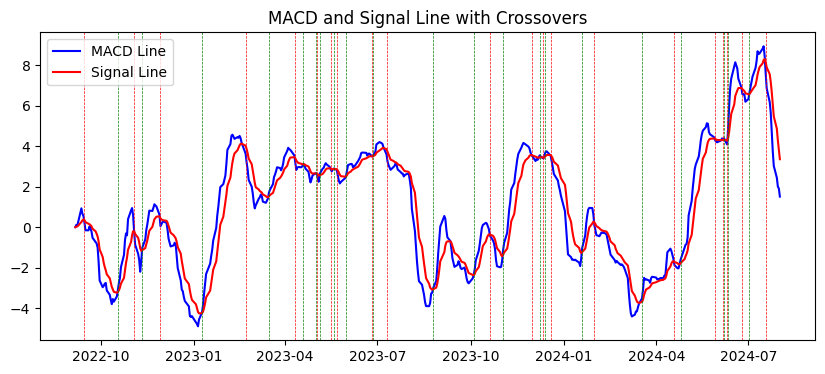

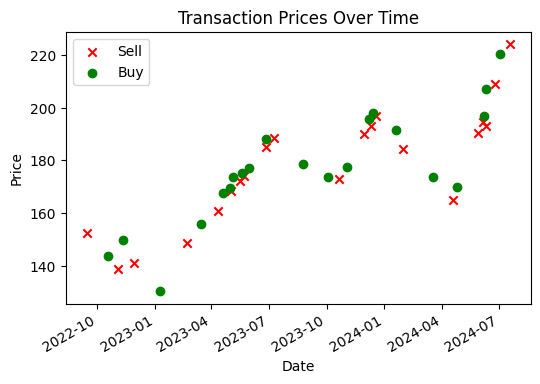

Running Simulation for MACD with AAPL from 2022-08-01 to 2024-08-01
Number of Transactions:  42
Buys:  21 Sells:  21
Open Price, Close Price:  154.53 218.36
Beginning Cash and Shares:  500000.0 3235.617679415
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  500000.0 3280.4005826274783
End Portfolio Value:  1216308.2712225362

Model Profit Percentage:  21.63082712225362
Market Change w/o trades 20.65294764770595

Model outperforms market by 0.9778794745476702 %


Invest RSI for MSFT from 2022-08-01 to 2024-08-01
Number of Data Points: 479


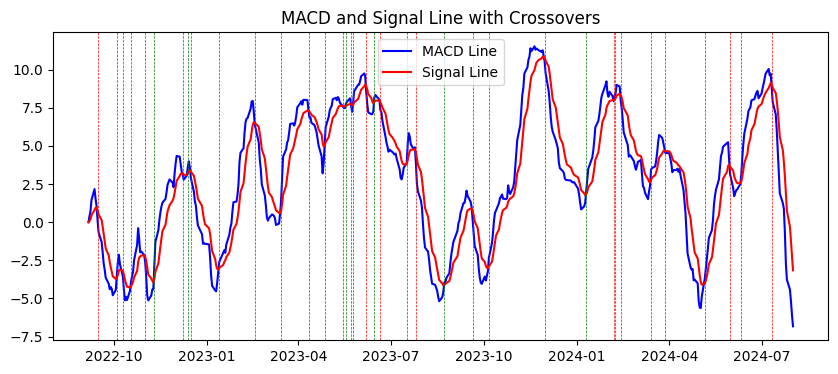

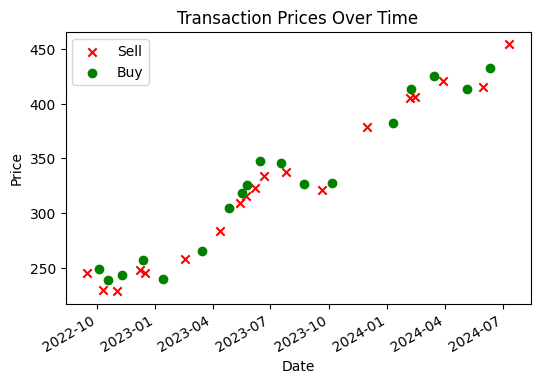

Running Simulation for MACD with MSFT from 2022-08-01 to 2024-08-01
Number of Transactions:  37
Buys:  18 Sells:  19
Open Price, Close Price:  253.25 417.11
Beginning Cash and Shares:  500000.0 1974.3336623889438
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  550000.0 1782.7040120660843
End Portfolio Value:  1293583.6704728846

Model Profit Percentage:  29.358367047288453
Market Change w/o trades 32.35143139190524

Model outperforms market by -2.9930643446167835 %


Invest RSI for GOOGL from 2022-08-01 to 2024-08-01
Number of Data Points: 479


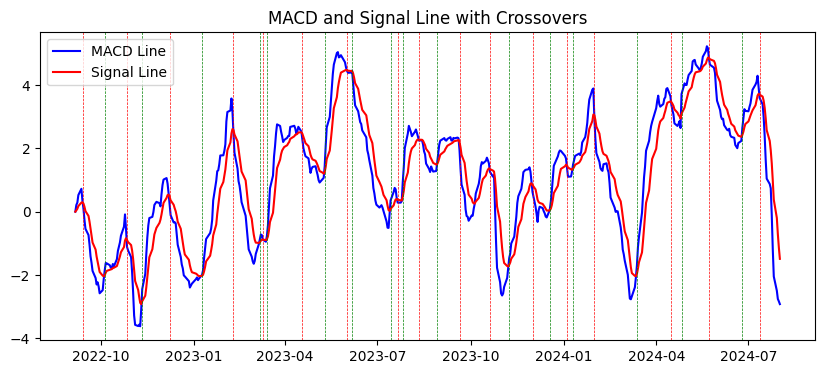

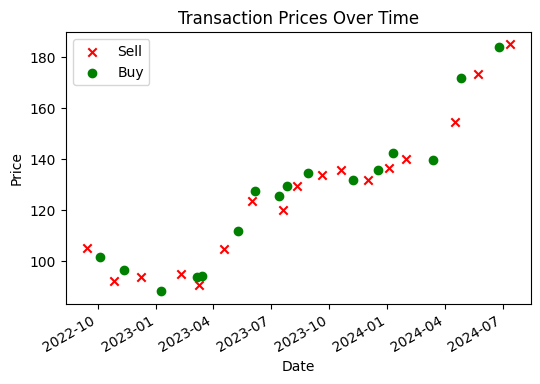

Running Simulation for MACD with GOOGL from 2022-08-01 to 2024-08-01
Number of Transactions:  33
Buys:  16 Sells:  17
Open Price, Close Price:  106.81 170.76
Beginning Cash and Shares:  500000.0 4681.209624566988
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  550000.0 4299.425767368293
End Portfolio Value:  1284169.9440358097

Model Profit Percentage:  28.41699440358097
Market Change w/o trades 29.936335549105884

Model outperforms market by -1.5193411455249155 %


Invest RSI for GOOG from 2022-08-01 to 2024-08-01
Number of Data Points: 479


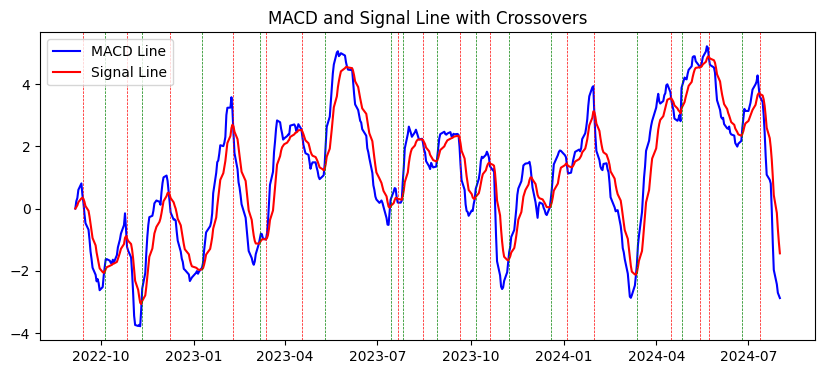

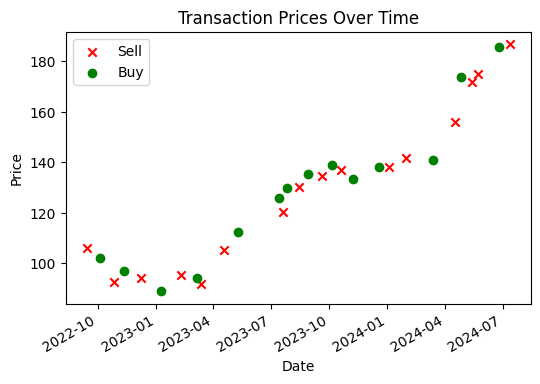

Running Simulation for MACD with GOOG from 2022-08-01 to 2024-08-01
Number of Transactions:  30
Buys:  14 Sells:  16
Open Price, Close Price:  107.48 172.45
Beginning Cash and Shares:  500000.0 4652.028284331968
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  600000.0 3854.6085312802643
End Portfolio Value:  1264727.2412192817

Model Profit Percentage:  26.47272412192817
Market Change w/o trades 30.22422776330479

Model outperforms market by -3.751503641376619 %


Invest RSI for AMZN from 2022-08-01 to 2024-08-01
Number of Data Points: 479


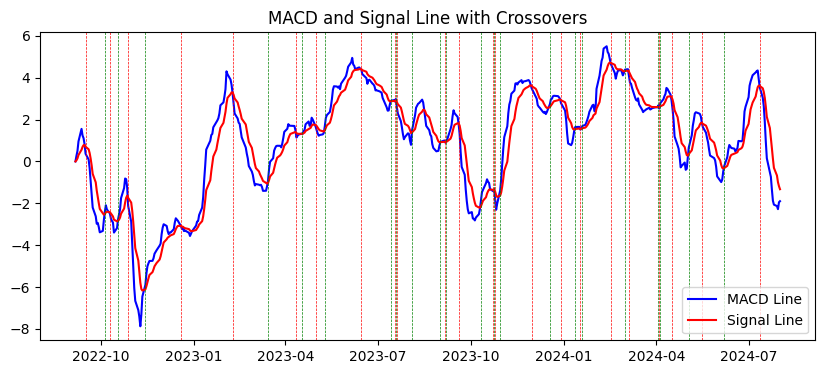

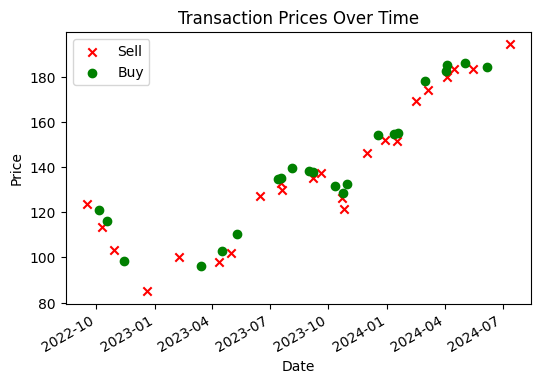

Running Simulation for MACD with AMZN from 2022-08-01 to 2024-08-01
Number of Transactions:  45
Buys:  22 Sells:  23
Open Price, Close Price:  126.11 184.07
Beginning Cash and Shares:  500000.0 3964.7926413448577
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  550000.0 3303.887883517246
End Portfolio Value:  1158146.6427190194

Model Profit Percentage:  15.814664271901943
Market Change w/o trades 22.97993814923479

Model outperforms market by -7.165273877332847 %


Waiting for 60 seconds to avoid rate limit
Invest RSI for TSLA from 2022-08-01 to 2024-08-01
Number of Data Points: 479


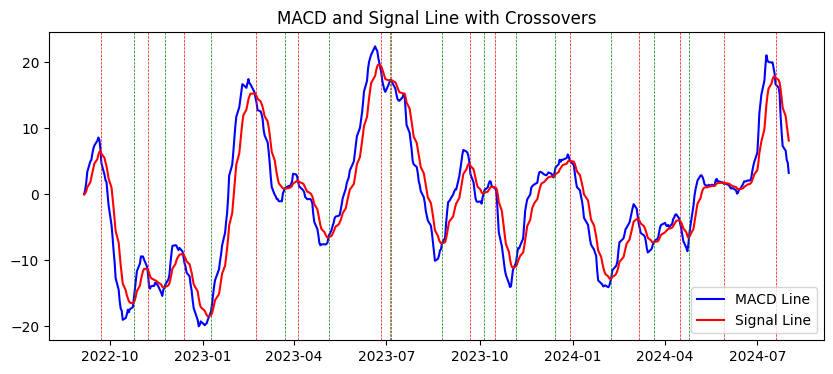

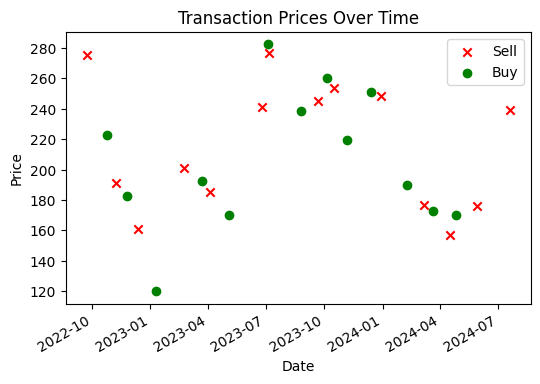

Running Simulation for MACD with TSLA from 2022-08-01 to 2024-08-01
Number of Transactions:  27
Buys:  13 Sells:  14
Open Price, Close Price:  274.42 216.86
Beginning Cash and Shares:  500000.0 1822.0246337730484
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  550000.0 1787.8860075791636
End Portfolio Value:  937720.9596036174

Model Profit Percentage:  -6.227904039638257
Market Change w/o trades -10.487573791997667

Model outperforms market by 4.25966975235941 %


Invest RSI for NVDA from 2022-08-01 to 2024-08-01
Number of Data Points: 479


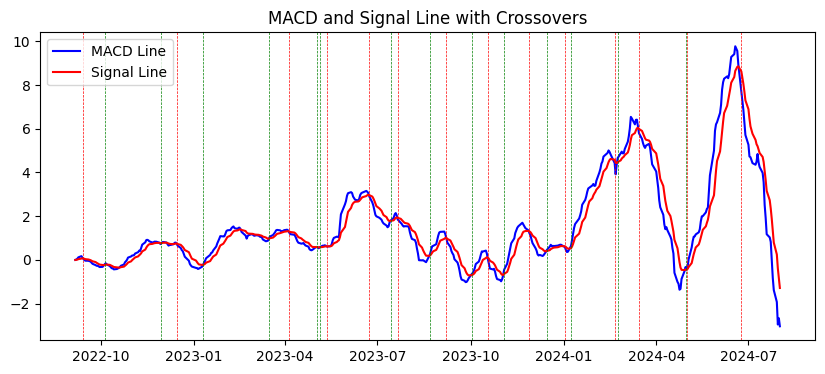

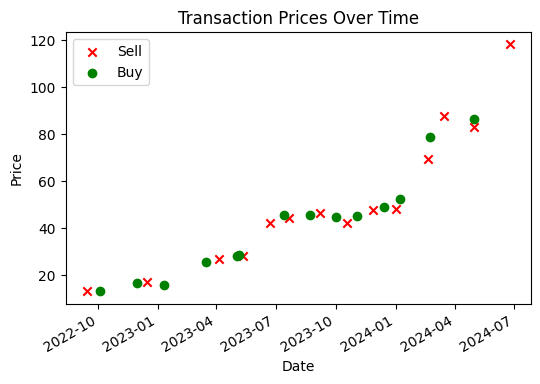

Running Simulation for MACD with NVDA from 2022-08-01 to 2024-08-01
Number of Transactions:  28
Buys:  14 Sells:  14
Open Price, Close Price:  13.465 109.21
Beginning Cash and Shares:  500000.0 37133.30857779428
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  500000.0 40744.184673204174
End Portfolio Value:  4949672.408160628

Model Profit Percentage:  394.9672408160628
Market Change w/o trades 355.5328629780913

Model outperforms market by 39.43437783797151 %


Invest RSI for BRK.B from 2022-08-01 to 2024-08-01
Number of Data Points: 479


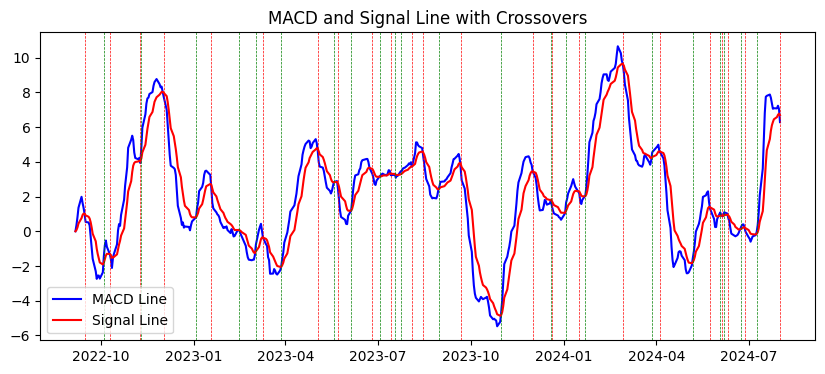

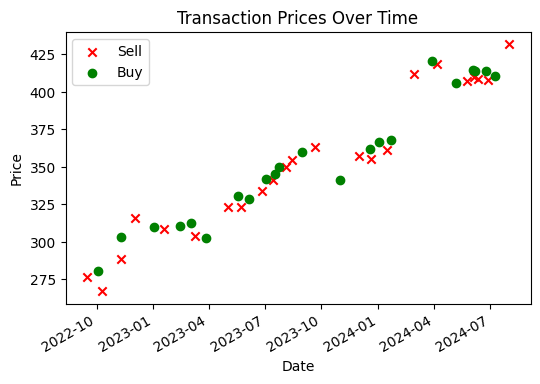

Running Simulation for MACD with BRK.B from 2022-08-01 to 2024-08-01
Number of Transactions:  45
Buys:  22 Sells:  23
Open Price, Close Price:  276.59 431.81
Beginning Cash and Shares:  500000.0 1807.7298528507902
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  550000.0 1638.7916083559344
End Portfolio Value:  1257646.6044041761

Model Profit Percentage:  25.764660440417614
Market Change w/o trades 28.05958277594997

Model outperforms market by -2.2949223355323554 %


Invest RSI for META from 2022-08-01 to 2024-08-01
Number of Data Points: 479


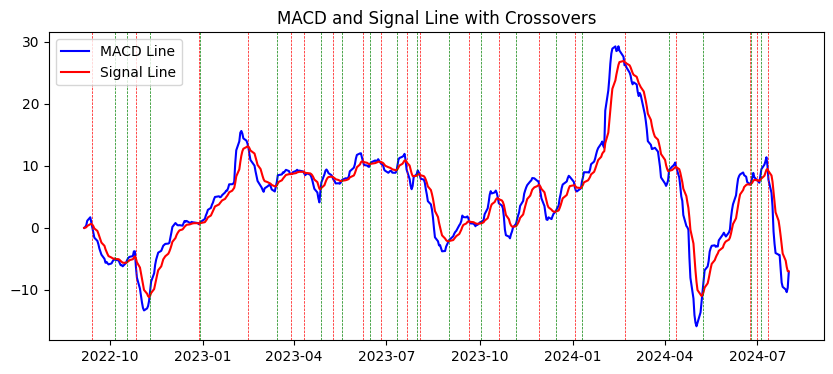

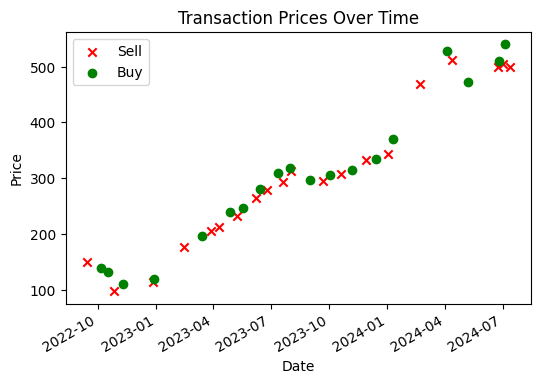

Running Simulation for MACD with META from 2022-08-01 to 2024-08-01
Number of Transactions:  39
Buys:  19 Sells:  20
Open Price, Close Price:  158.54 497.74
Beginning Cash and Shares:  500000.0 3153.7782263151257
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  550000.0 3001.65893585798
End Portfolio Value:  2044045.718733951

Model Profit Percentage:  104.40457187339508
Market Change w/o trades 106.97615743660909

Model outperforms market by -2.5715855632140006 %


Invest RSI for UNH from 2022-08-01 to 2024-08-01
Number of Data Points: 479


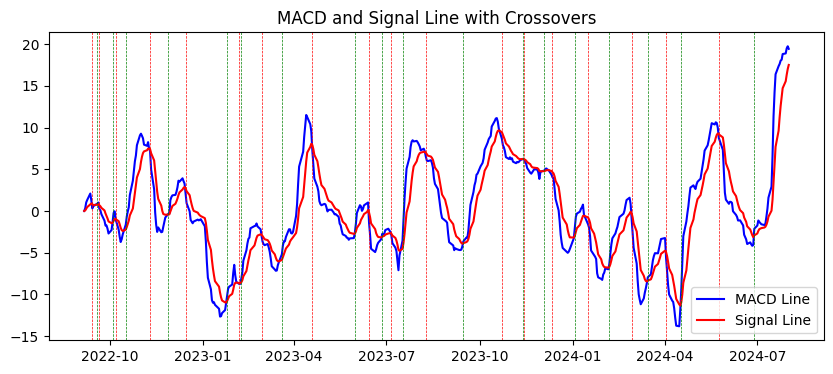

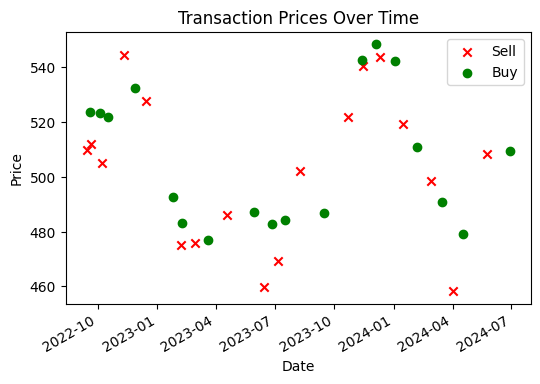

Running Simulation for MACD with UNH from 2022-08-01 to 2024-08-01
Number of Transactions:  36
Buys:  18 Sells:  18
Open Price, Close Price:  517.68 572.77
Beginning Cash and Shares:  500000.0 965.847627878226
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  500000.0 952.8176626103706
End Portfolio Value:  1045745.3726133419

Model Profit Percentage:  4.57453726133419
Market Change w/o trades 5.32085458198115

Model outperforms market by -0.74631732064696 %


Waiting for 60 seconds to avoid rate limit
Invest RSI for JNJ from 2022-08-01 to 2024-08-01
Number of Data Points: 479


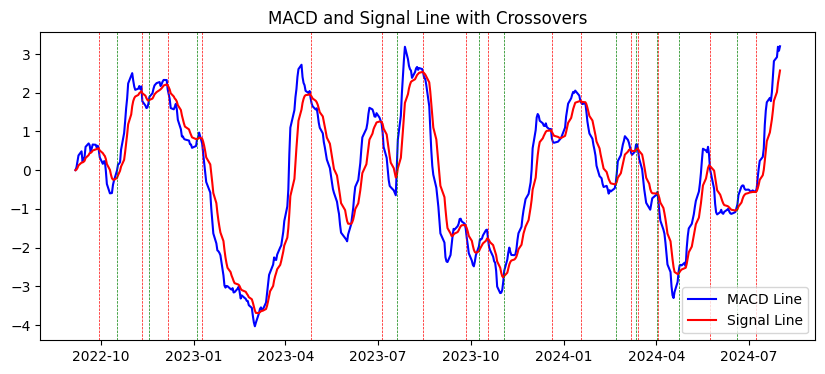

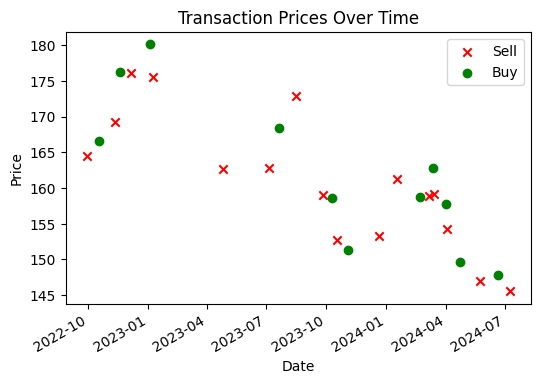

Running Simulation for MACD with JNJ from 2022-08-01 to 2024-08-01
Number of Transactions:  27
Buys:  11 Sells:  16
Open Price, Close Price:  163.18 160.76
Beginning Cash and Shares:  500000.0 3064.1009927687214
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  750000.0 1493.60200422381
End Portfolio Value:  990111.4581990197

Model Profit Percentage:  -0.988854180098034
Market Change w/o trades -0.7415124402500355

Model outperforms market by -0.24734173984799857 %


Invest RSI for V from 2022-08-01 to 2024-08-01
Number of Data Points: 479


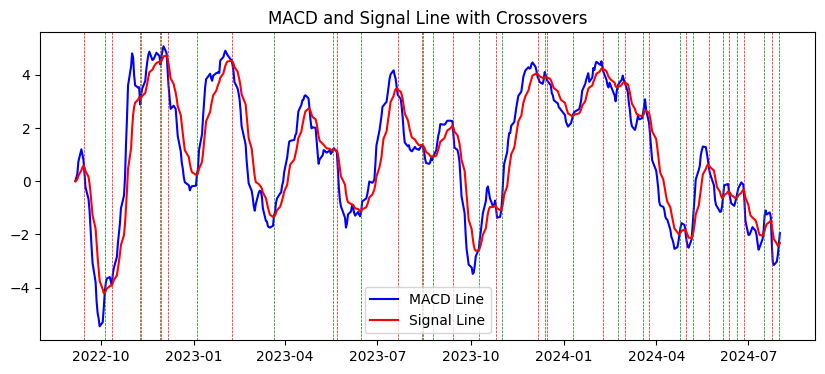

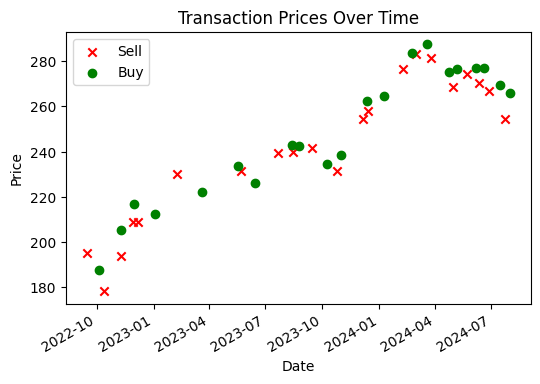

Running Simulation for MACD with V from 2022-08-01 to 2024-08-01
Number of Transactions:  42
Buys:  21 Sells:  21
Open Price, Close Price:  198.64 265.93
Beginning Cash and Shares:  500000.0 2517.1163914619415
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  500000.0 2405.0619846887093
End Portfolio Value:  1139578.1335882684

Model Profit Percentage:  13.957813358826844
Market Change w/o trades 16.937676198147408

Model outperforms market by -2.979862839320564 %


Invest RSI for WMT from 2022-08-01 to 2024-08-01
Number of Data Points: 479


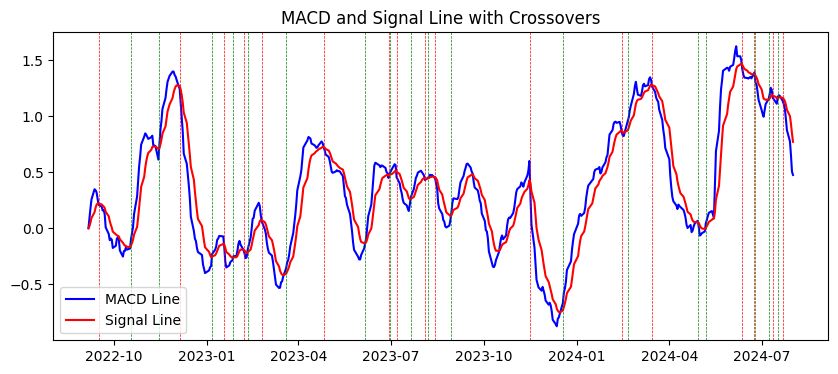

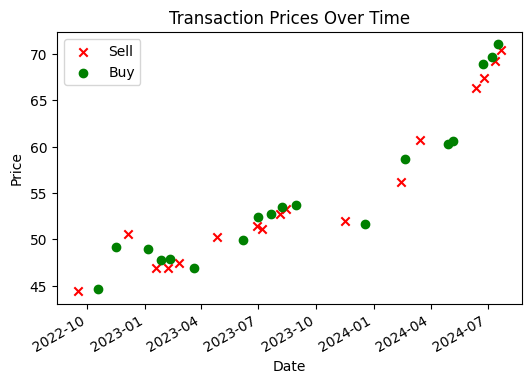

Running Simulation for MACD with WMT from 2022-08-01 to 2024-08-01
Number of Transactions:  35
Buys:  18 Sells:  17
Open Price, Close Price:  44.1133 69.79
Beginning Cash and Shares:  500000.0 11334.450154488555
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  450000.0 12307.03498813603
End Portfolio Value:  1308907.9718220136

Model Profit Percentage:  30.890797182201364
Market Change w/o trades 29.103127628175635

Model outperforms market by 1.7876695540257295 %


Invest RSI for XOM from 2022-08-01 to 2024-08-01
Number of Data Points: 479


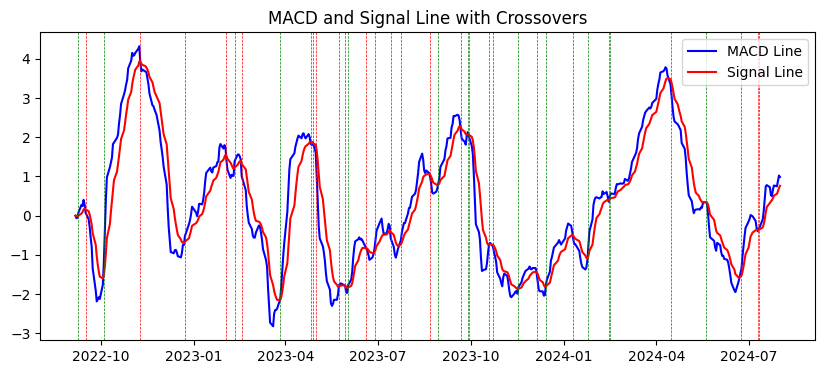

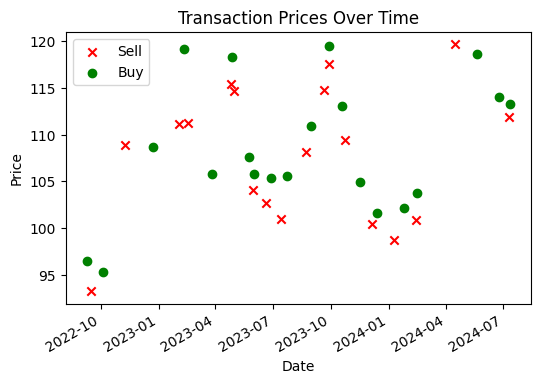

Running Simulation for MACD with XOM from 2022-08-01 to 2024-08-01
Number of Transactions:  38
Buys:  20 Sells:  18
Open Price, Close Price:  94.95 116.95
Beginning Cash and Shares:  500000.0 5265.92943654555
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  400000.0 6150.991193081628
End Portfolio Value:  1119358.4200308966

Model Profit Percentage:  11.935842003089656
Market Change w/o trades 11.585044760400208

Model outperforms market by 0.35079724268944723 %


Invest RSI for PG from 2022-08-01 to 2024-08-01
Number of Data Points: 479


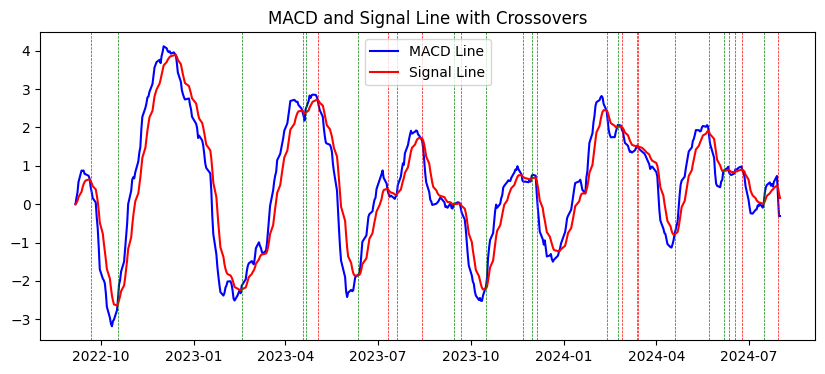

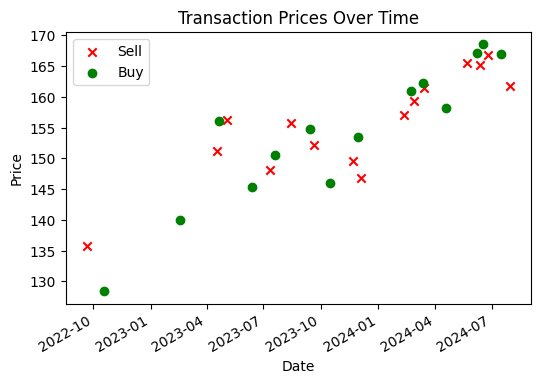

Running Simulation for MACD with PG from 2022-08-01 to 2024-08-01
Number of Transactions:  29
Buys:  14 Sells:  15
Open Price, Close Price:  135.63 165.69
Beginning Cash and Shares:  500000.0 3686.5000368650003
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  550000.0 3413.987572916593
End Portfolio Value:  1115663.6009565503

Model Profit Percentage:  11.566360095655034
Market Change w/o trades 11.081619110816192

Model outperforms market by 0.484740984838842 %


Waiting for 60 seconds to avoid rate limit
Invest RSI for JPM from 2022-08-01 to 2024-08-01
Number of Data Points: 479


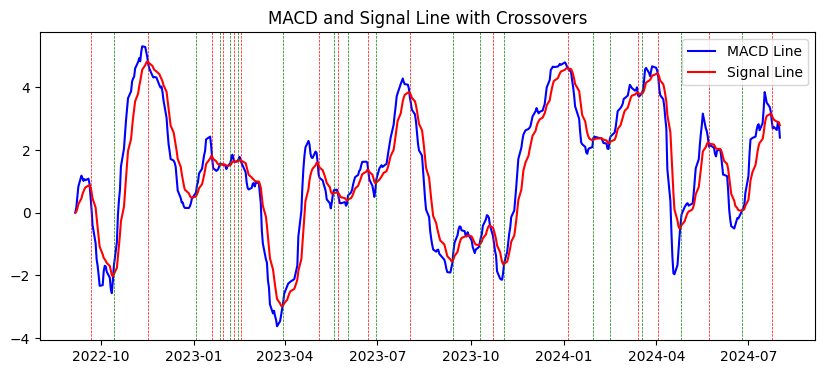

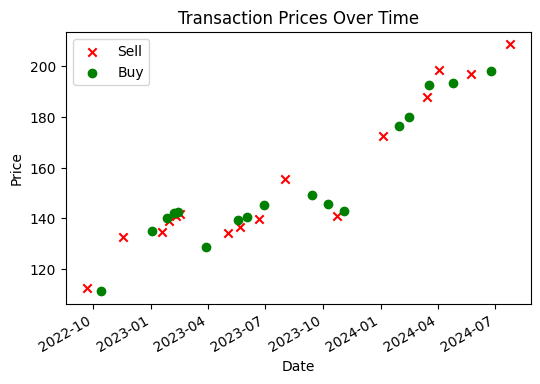

Running Simulation for MACD with JPM from 2022-08-01 to 2024-08-01
Number of Transactions:  33
Buys:  17 Sells:  16
Open Price, Close Price:  113.74 207.96
Beginning Cash and Shares:  500000.0 4395.990856339019
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  450000.0 4747.831774769834
End Portfolio Value:  1437359.0958811347

Model Profit Percentage:  43.73590958811347
Market Change w/o trades 41.419025848426244

Model outperforms market by 2.3168837396872277 %


Invest RSI for MA from 2022-08-01 to 2024-08-01
Number of Data Points: 479


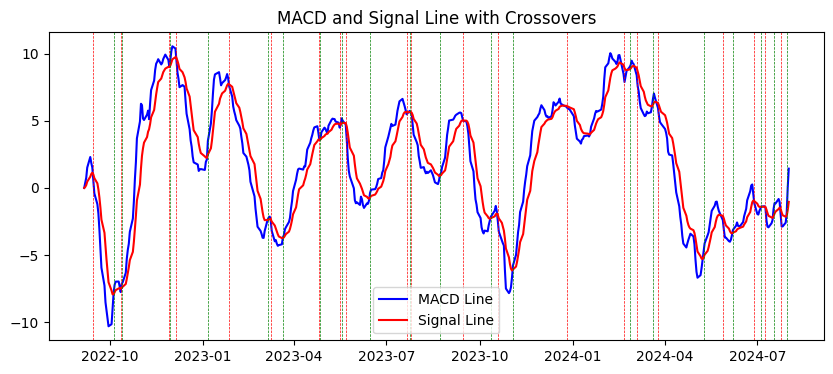

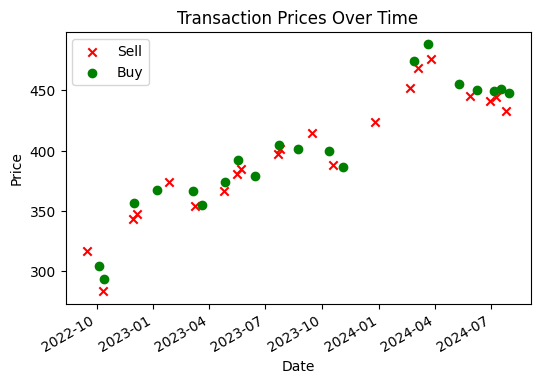

Running Simulation for MACD with MA from 2022-08-01 to 2024-08-01
Number of Transactions:  41
Buys:  20 Sells:  21
Open Price, Close Price:  324.08 462.41
Beginning Cash and Shares:  500000.0 1542.8289311281167
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  550000.0 1398.8667159914469
End Portfolio Value:  1196849.958141605

Model Profit Percentage:  19.68499581416049
Market Change w/o trades 21.341952604295244

Model outperforms market by -1.6569567901347533 %


Invest RSI for LLY from 2022-08-01 to 2024-08-01
Number of Data Points: 479


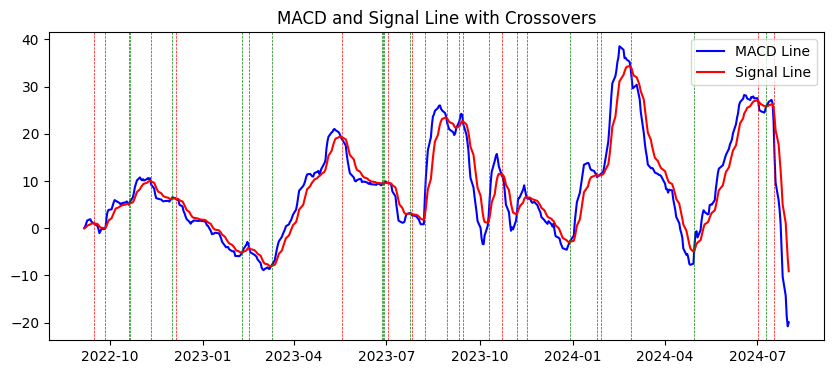

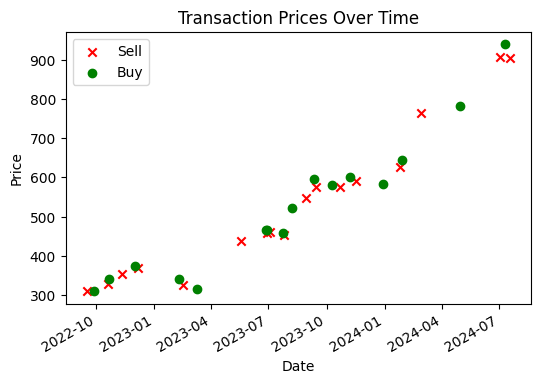

Running Simulation for MACD with LLY from 2022-08-01 to 2024-08-01
Number of Transactions:  33
Buys:  16 Sells:  17
Open Price, Close Price:  306.82 832.44
Beginning Cash and Shares:  500000.0 1629.6199726223845
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  550000.0 1538.394387377297
End Portfolio Value:  1830621.0238283572

Model Profit Percentage:  83.06210238283572
Market Change w/o trades 85.65608500097778

Model outperforms market by -2.593982618142064 %


Invest RSI for HD from 2022-08-01 to 2024-08-01
Number of Data Points: 479


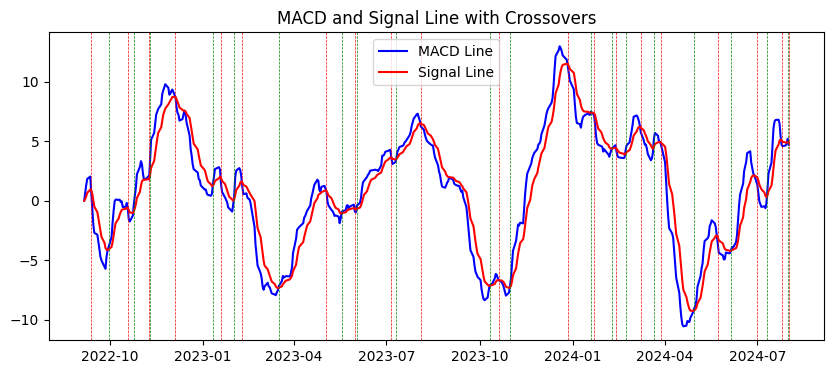

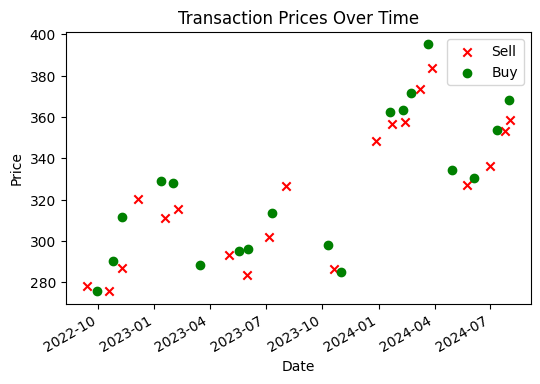

Running Simulation for MACD with HD from 2022-08-01 to 2024-08-01
Number of Transactions:  39
Buys:  19 Sells:  20
Open Price, Close Price:  289.54 358.58
Beginning Cash and Shares:  500000.0 1726.8771154244662
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  550000.0 1552.655296124543
End Portfolio Value:  1106751.1360843387

Model Profit Percentage:  10.675113608433865
Market Change w/o trades 11.922359604890508

Model outperforms market by -1.247245996456643 %


Invest RSI for CVX from 2022-08-01 to 2024-08-01
Number of Data Points: 479


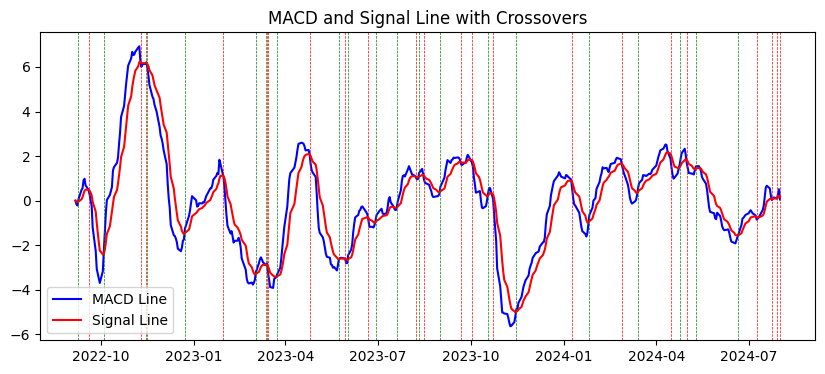

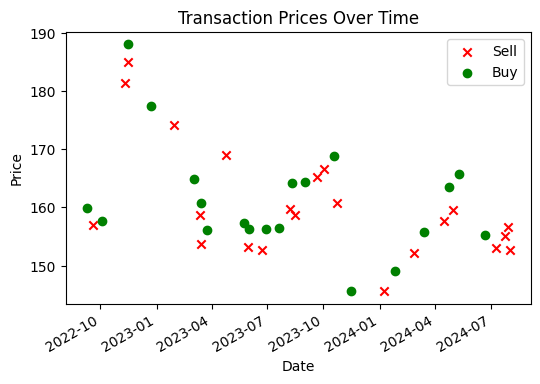

Running Simulation for MACD with CVX from 2022-08-01 to 2024-08-01
Number of Transactions:  42
Buys:  20 Sells:  22
Open Price, Close Price:  157.12 152.62
Beginning Cash and Shares:  500000.0 3182.2810590631366
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  600000.0 2523.111368145794
End Portfolio Value:  985077.2570064111

Model Profit Percentage:  -1.4922742993588909
Market Change w/o trades -1.4320264765784116

Model outperforms market by -0.06024782278047924 %


Waiting for 60 seconds to avoid rate limit
Invest RSI for MRK from 2022-08-01 to 2024-08-01
Number of Data Points: 479


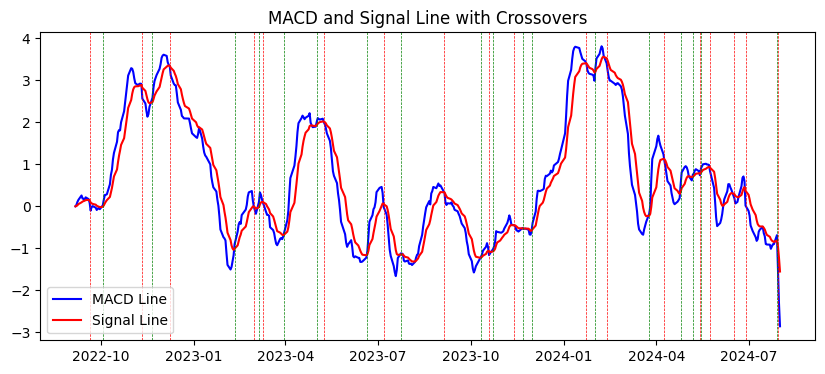

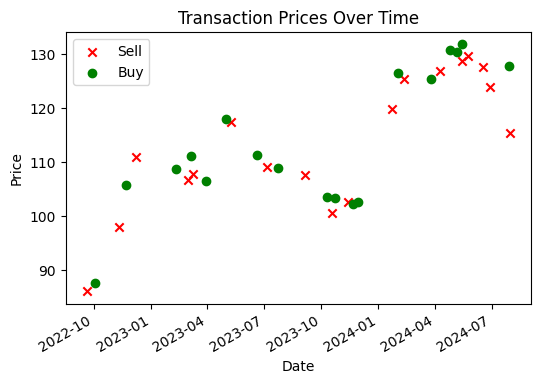

Running Simulation for MACD with MRK from 2022-08-01 to 2024-08-01
Number of Transactions:  36
Buys:  18 Sells:  18
Open Price, Close Price:  86.42 113.82
Beginning Cash and Shares:  500000.0 5785.697755149271
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  500000.0 5793.237560520638
End Portfolio Value:  1159386.299138459

Model Profit Percentage:  15.938629913845892
Market Change w/o trades 15.852811849108997

Model outperforms market by 0.08581806473689468 %


Invest RSI for PEP from 2022-08-01 to 2024-08-01
Number of Data Points: 479


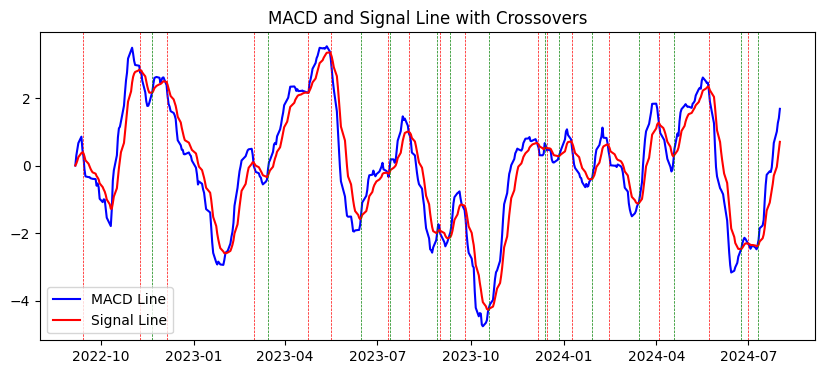

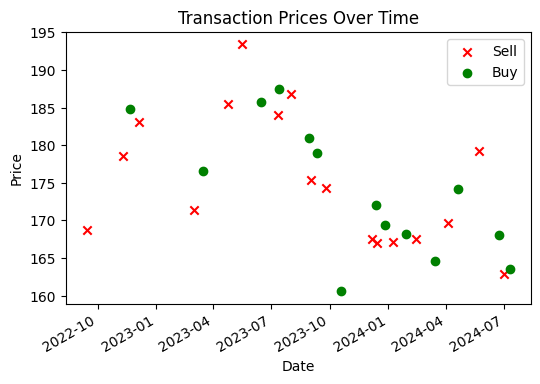

Running Simulation for MACD with PEP from 2022-08-01 to 2024-08-01
Number of Transactions:  31
Buys:  14 Sells:  17
Open Price, Close Price:  169.51 174.96
Beginning Cash and Shares:  500000.0 2949.6784850451304
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  650000.0 2126.635550925525
End Portfolio Value:  1022076.1559899298

Model Profit Percentage:  2.20761559899298
Market Change w/o trades 1.6075747743496012

Model outperforms market by 0.600040824643379 %


Invest RSI for ABBV from 2022-08-01 to 2024-08-01
Number of Data Points: 479


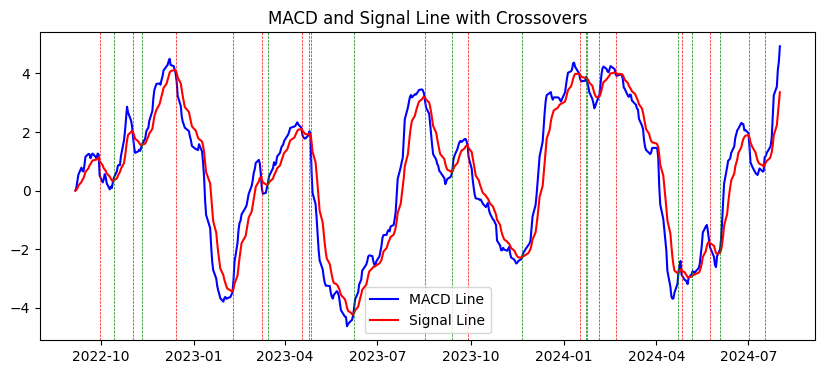

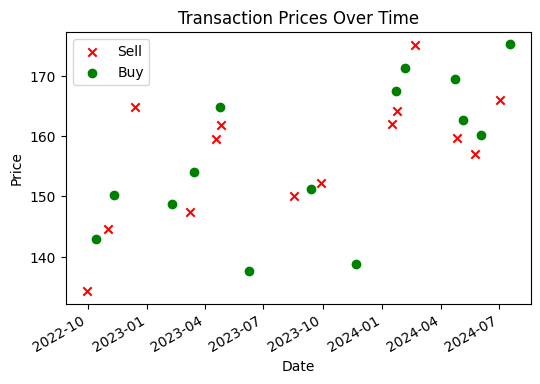

Running Simulation for MACD with ABBV from 2022-08-01 to 2024-08-01
Number of Transactions:  28
Buys:  14 Sells:  14
Open Price, Close Price:  137.59 189.71
Beginning Cash and Shares:  500000.0 3633.9850279816847
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  500000.0 3648.708742686533
End Portfolio Value:  1192196.535575062

Model Profit Percentage:  19.219653557506202
Market Change w/o trades 18.94032996584054

Model outperforms market by 0.279323591665662 %


Invest RSI for KO from 2022-08-01 to 2024-08-01
Number of Data Points: 479


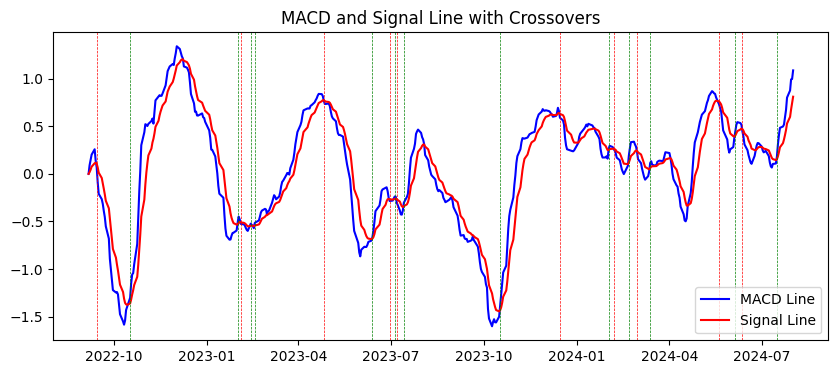

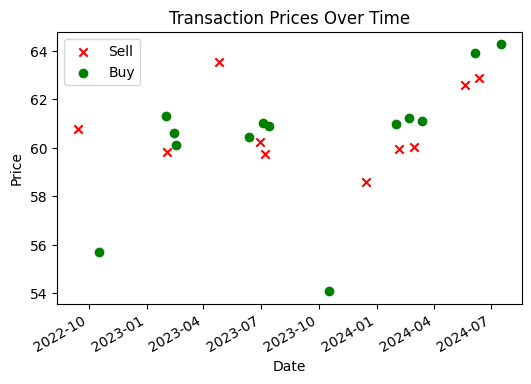

Running Simulation for MACD with KO from 2022-08-01 to 2024-08-01
Number of Transactions:  23
Buys:  13 Sells:  10
Open Price, Close Price:  61.18 67.96
Beginning Cash and Shares:  500000.0 8172.605426610004
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  350000.0 10722.691753908332
End Portfolio Value:  1078714.1315956102

Model Profit Percentage:  7.871413159561018
Market Change w/o trades 5.5410264792415775

Model outperforms market by 2.3303866803194406 %


Invest RSI for SPY from 2022-08-01 to 2024-08-01
Number of Data Points: 479


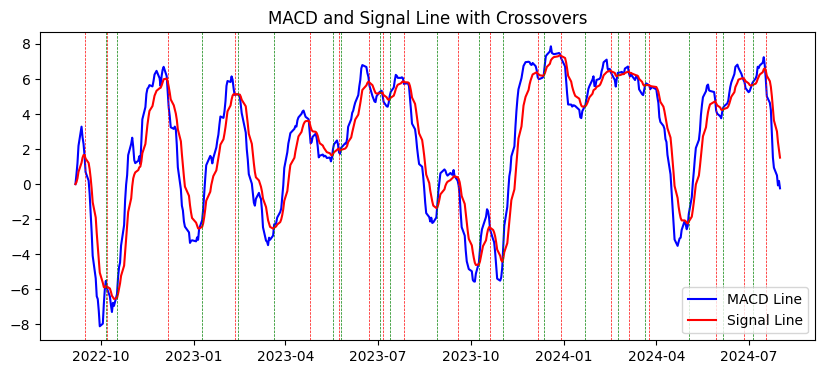

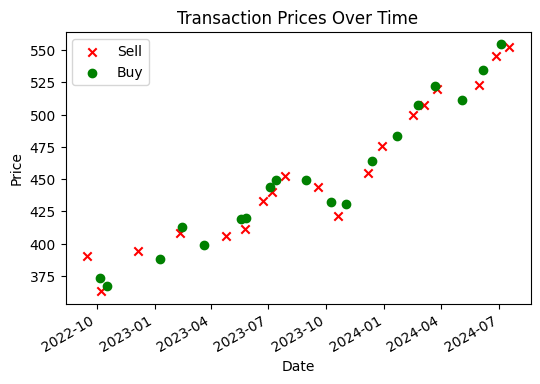

Running Simulation for MACD with SPY from 2022-08-01 to 2024-08-01
Number of Transactions:  38
Buys:  19 Sells:  19
Open Price, Close Price:  390.76 543.01
Beginning Cash and Shares:  500000.0 1279.557784829563
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  500000.0 1298.1582914586825
End Portfolio Value:  1204912.9338449792

Model Profit Percentage:  20.491293384497915
Market Change w/o trades 19.481267274030095

Model outperforms market by 1.0100261104678196 %


Alphas for each stock: {'AAPL': 0.9778794745476702, 'MSFT': -2.9930643446167835, 'GOOGL': -1.5193411455249155, 'GOOG': -3.751503641376619, 'AMZN': -7.165273877332847, 'TSLA': 4.25966975235941, 'NVDA': 39.43437783797151, 'BRK.B': -2.2949223355323554, 'META': -2.5715855632140006, 'UNH': -0.74631732064696, 'JNJ': -0.24734173984799857, 'V': -2.979862839320564, 'WMT': 1.7876695540257295, 'XOM': 0.35079724268944723, 'PG': 0.484740984838842, 'JPM': 2.3168837396872277, 'MA': -1.6569567901347533, 'LLY': -2.593982618142064

In [5]:
#test
# tickers = ["AMD", "ARM", "ARM", "ABNB", "NVDA"]
tickers = top_25_tickers
start_date = "2022-08-01"
end_date =  "2024-08-01"
initial_portfolio_value = 1000000
count = 0

for ticker in tickers:
    if count % 5 == 0 and count != 0:
        print("Waiting for 60 seconds to avoid rate limit")
        time.sleep(60)
    count += 1
        

    print("Invest RSI for", ticker, "from" , start_date, "to" , end_date)
    
    data = get_data(ticker, start_date, end_date)
    # replace start price with start price of stock (you can find it in yahoo finance)
    start_price = data[0].close
   
    initial_cash = 0.5 * initial_portfolio_value
    initial_shares = (0.5 * initial_portfolio_value/start_price) if start_price > 0 else 1000
    percent_invest = 10
    alpha, profit = test_model(ticker, data, start_date, end_date, initial_cash, initial_shares, percent_invest) # can only run for about 1.5 yrs
    alphas_dict[ticker] = alpha
    print()
    print()
    

print("Alphas for each stock:", alphas_dict)


Average Alpha:  0.963598712921042


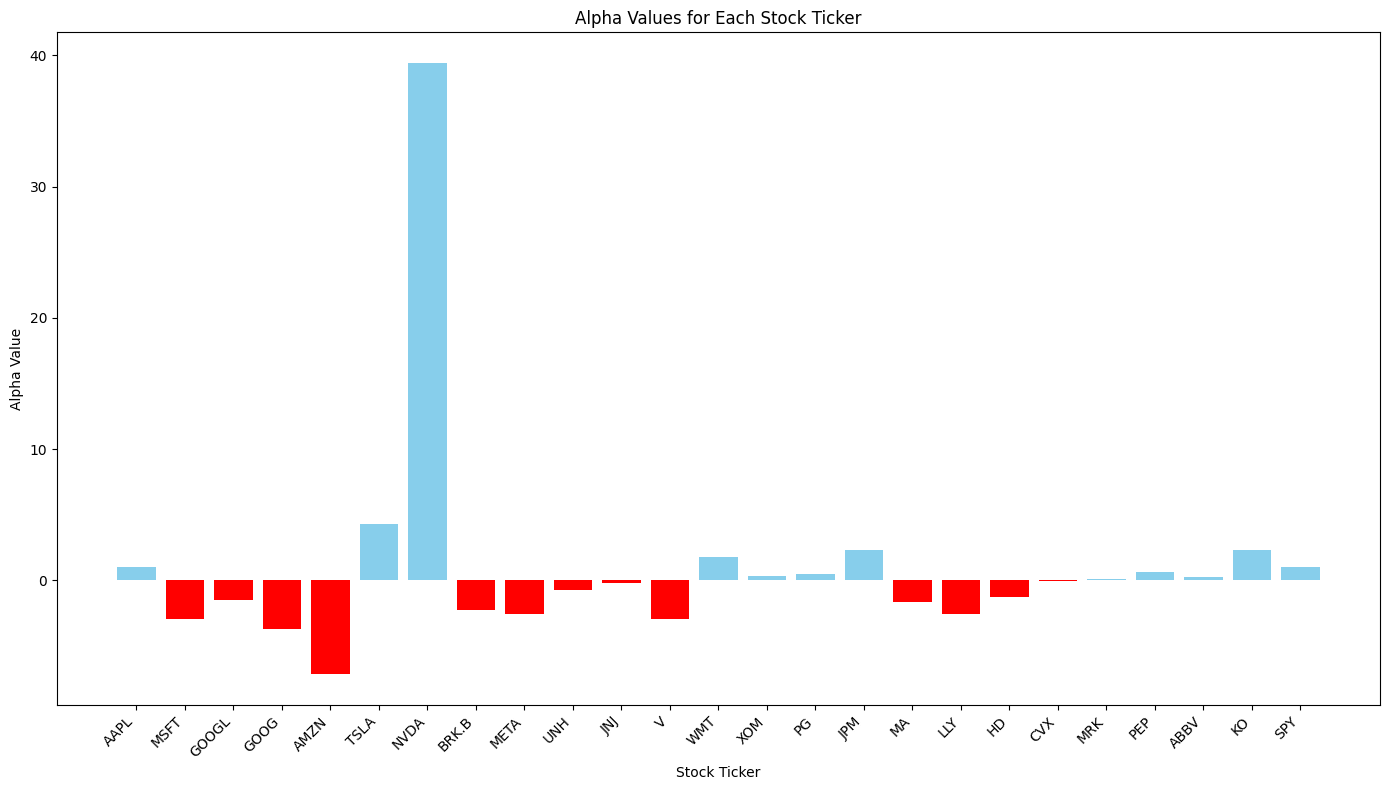

In [6]:
# Create lists of tickers and corresponding alphas
tickers = list(alphas_dict.keys())
alphas = list(alphas_dict.values())
print("Average Alpha: ", sum(alphas)/len(alphas))

colors = ['red' if alpha < 0 else 'skyblue' for alpha in alphas]  # Red for negative, blue for positive

# Plotting the data
plt.figure(figsize=(14, 8))
plt.bar(tickers, alphas, color=colors)

# Labels and title
plt.xlabel('Stock Ticker')
plt.ylabel('Alpha Value')
plt.title('Alpha Values for Each Stock Ticker')

# Rotate the x labels for better readability
plt.xticks(rotation=45, ha='right')


# Show the plot
plt.tight_layout()
plt.show()